# Introduction

This notebook describes the solution of the Minigrid game in the Key environment using DQN.

**Notebook Structure:**

The notebook has 3 parts:

- **Part 1: Source Code** -  Contains all the essential code needed to solve the environment, run experiments, and generate reports.

- **Part 2: Optimal Solution Presentation** -   Demonstrates the optimal configuration.

- **Part 3: Hyperparameter Tuning and Experiments** - Explores the impact of hyperparameter adjustments on the optimal configuration and the resulting policies.

**Environment Types Discussed:**
- **Constant Environment:** The locations of the goal, key, door, and agent's starting point are fixed across all episodes.
- **Stochastic Environment:** The locations vary between episodes, as occurs with resets in the original Minigrid environment.

**Additional Information:**

The code is well-organized and thoroughly documented for clarity. Visual reports and summarizing metrics are produced. For a detailed comparison and additional insights, please refer to the report.

# Part 1: Source Code

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

## Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
import seaborn as sns
import gym_minigrid
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy import load
from numpy import save
import numpy as np
import pandas as pd
import cv2
from base64 import b64encode
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from collections import namedtuple, deque
import copy
import random
import matplotlib.pyplot as plt
from enum import Enum
from abc import ABC, abstractmethod
from tqdm import tqdm
import torch.nn.functional as F

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


## Display utils

In [ ]:
def create_video(images):
  video_filename = 'imageio.mp4'
  with imageio.get_writer(video_filename, fps=10) as video:
      for image in images: video.append_data(image)

  video = open(video_filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Env

In [ ]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random


class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir



        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)


        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def get_g_pos(self):
      return self.goal_pos

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        # self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        # self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))



        ## change 21-09 for random env - add player position
        # self.goal_pos = (0, 0)
        # while self.goal_pos in self.not_goal_loc:
        #   self.goal_pos = (random.randint(1, width - 2), random.randint(1, height - 2))
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])


        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place a goal square in the bottom-right corner
        # self.put_obj(Goal(), width - 2, height - 2)


        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

## Wrappers

In [ ]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import copy
max_env_steps = 100

class SimFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'
      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()


class KeyFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
      return self.unwrapped.goal_pos

    def get_door_pos(self):
      return self.unwrapped.door_pos

    def get_key_pos(self):
      return self.unwrapped.key_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      # map_u[self.unwrapped.width-2][self.unwrapped.height-2] = 'G'
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      if not self.is_door_open():
        door_col, door_row = self.unwrapped.door_pos
        map_up[door_row][door_col] = 'D'
        if not self.is_carrying_key():
          key_col, key_row = self.unwrapped.key_pos
          map_up[key_row][key_col] = 'K'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'

      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()

## Environment Customization
The following classes have been developed to encapsulate existing wrappers to facilitate easier customization of the environment for coding purposes, such as simplifying the process of reward shaping.

In [ ]:
class EnvType(Enum):
    EMPTY = 0
    KEY = 1

class EnvStochasticity(Enum):
    CONSTANT = 0
    STOCHASTIC = 1

agent_directions_space = 4
key_state_space = 2
door_state_space = 2

key_picked_up_reward = 1 # these are constant rewards
door_unlocked_reward = 1

class Direction(Enum):
    RIGHT = 0
    DOWN = 1
    LEFT = 2
    UP = 3

class StateRepresentation(Enum):
    IMAGE = 'image'
    ENCODED = 'encoded'

class EnvWrapper(gym.Env, ABC):
    '''
    This wrapper enables environment customization
    '''
    def __init__(self, env, step_reward=-0.01, goal_reward=10, state_representation=StateRepresentation.ENCODED, env_stochasticity=EnvStochasticity.CONSTANT):
        '''
        Initializes the EnvWrapper.

        Args:
            env (gym.Env): The Gym environment to be wrapped. Important: this env must be initialized before wrapping (use env.reset())
            step_reward (float, optional): The per-step reward or penalty. Default is -0.01.
            goal_reward (float, optional): The reward for reaching the goal. Default is 10.
            state_representation (StateRepr, optional): The state representation mode.
                                                        Use StateRepr.IMAGE for a full image representation, or StateRepr.ENCODED for an encoded version
                                                        Default is StateRepr.ENCODED
             env_stochasticity (EnvStochasticity, optional): The environmental stochasticity setting.
                                                        Use EnvStochasticity.CONSTANT to keep artifacts in their place upon reset,
                                                        or EnvStochasticity.STOCHASTIC to allow them to change upon reset.
                                                        Default is EnvStochasticity.CONSTANT.
        '''
        self.state_representation = state_representation
        self.is_constant = EnvStochasticity.CONSTANT == env_stochasticity

        if self.is_constant:
            self.source_env = env # keep track of the original env
        else:
            self.env = env

        self.set_params(step_reward, goal_reward)
        self.render_hash = {}
        self.reset()

    def reset(self):
        if self.is_constant:
            self.env = copy.deepcopy(self.source_env) # open gym default implementation changes the board. override, as we do not want to change the board upon reset every time
        else:
            self.env.reset()
        return self.get_current_state()

    def set_params(self, step_reward, goal_reward):
        self.step_reward = step_reward
        self.goal_reward = goal_reward

    def get_current_state(self):
        encoded_state = self.get_encoded_current_state()
        if StateRepresentation.IMAGE == self.state_representation:
            if encoded_state in self.render_hash:
                return self.render_hash[encoded_state]
            else:
                current_state = self.env.render()
                image = self.preprocess_image(current_state)
                self.render_hash[encoded_state] = image
                return image
        else:
            return encoded_state

    def preprocess_image(self, image):
        # step 1: make grayscale
        grayscale_image = image.mean(axis=2)
        # step 2: crop irrelenvant borders
        height, width = grayscale_image.shape
        crop_width = width // 10
        cropped_image = grayscale_image[crop_width:-crop_width, crop_width:-crop_width]
        # step 3: resize: sample every second pixel
        sampled_image = cropped_image[::2, ::2]
        # step 4: convert to black and white picture using a threshold found empirically of 80
        black_and_white_image = np.where(sampled_image > 80, 1, 0)
        return black_and_white_image

    def render(self):
        return self.env.render()

    def get_state_dim(self):
        if StateRepresentation.IMAGE == self.state_representation:
            state_dim = self.env.render().shape
        else: # this is encoded mode
            state_dim = self.get_encoded_state_dim()
        return state_dim

    def get_board_dims(self):
        cols = self.env.width - 2
        rows = self.env.height - 2
        return cols, rows

    def get_action_dim(self):
        return self.env.action_space.n

    def sample_action(self):
        available_actions = self.get_available_actions()
        sampled_action = random.choice(available_actions)
        return sampled_action

    def get_agent_position(self):
        col, row = self.env.get_position()
        return col - 1, row - 1

    @abstractmethod
    def get_available_actions(self):
        pass

    @abstractmethod
    def get_encoded_state_dim(self):
        pass

    @abstractmethod
    def get_encoded_current_state(self):
        pass

    @abstractmethod
    def step(self, action):
        pass

class EmptyEnvWrapper(EnvWrapper):
    def get_available_actions(self):
        available_actions = [0, 1]
        if not self.env.is_wall_front_pos(): # the agent is not standing in front of a wall - if so, we can proceed forward (2)
            available_actions.append(2)
        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        if self.is_constant:
            return (cols, rows,  # possible location of agent
                    agent_directions_space)
        else:
            return (cols, rows, # possible location of agent
                    agent_directions_space,
                    3) # 3 Possible location of the goal

    def get_goal_encoded_loc(self):
        col, row = self.env.get_goal_pos()
        if col == 8 and row == 1:
            return 0
        elif col == 1 and row == 8:
            return 1
        else: # col == 8 and row == 8:
            return 2

    def get_encoded_current_state(self):
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        if self.is_constant:
            state = (agent_col, agent_row, agent_direction)
            return state
        else:
            goal_encoded_loc = self.get_goal_encoded_loc()
            state = (agent_col, agent_row, agent_direction, goal_encoded_loc)
            return state

    def step(self, action):
        _ = self.env.step(action)
        s_tag = self.get_current_state()
        done = self.env.get_goal_pos() == self.env.get_position() # compare agent location to target location
        r = self.goal_reward if done else self.step_reward
        return s_tag, r, done

class KeyEnvWrapper(EnvWrapper):
    actions_dict = {0:0,
                  1:1,
                  2:2,
                  3:3,
                  4:5}
    def reset(self):
        self.was_key_picked_up = False
        self.was_door_unlocked = False
        return super().reset()

    def get_available_actions(self):
        available_actions = [0, 1]

        if (not self.env.is_carrying_key() and
                self.env.is_key_front_pos()):  # the agent is fronting a key - if so, we can use pick up action (3)
            available_actions.append(3)
        elif (not self.env.is_door_open() and
              self.env.is_carrying_key() and
              self.env.is_door_front_pos()):  # the agent is fronting a door it can open - if so, we can use toggle action (5)
            available_actions.append(4)
        elif (not self.env.is_wall_front_pos() or
            self.env.is_door_front_pos() and self.env.is_door_open()):  # the agent is not fronting a key, a closed door or a wall - if so, we can proceed forward (2)
            available_actions.append(2)

        return available_actions

    def get_encoded_state_dim(self):
        cols, rows = self.get_board_dims()
        if self.is_constant:
            return (cols, rows,  # agent location - 8X8 possibilities (ignoring door column)
                    agent_directions_space,  # 4 possible directions
                    key_state_space, door_state_space)  # add 2 more for key carring and door opening
        else:
            return (cols, rows, # agent location - 8X8 possibilities (ignoring door column)
                    agent_directions_space,  # 4 possible directions
                    2, rows, # key location - 2 possible columns X 8 rows
                    rows, # door location - 1 possible column X 8 rows
                    key_state_space, door_state_space)  # add 2 more for key carring and door opening

    def get_encoded_current_state(self):
        '''
        Note: the state holds the knowledge of the agent: the agent knows where it is and what its direction is,
        as well as some history of its actions: whether it has picked up the key or unlocked the door for the first time
        '''
        agent_col, agent_row = self.get_agent_position()
        agent_direction = self.env.get_direction()
        if self.is_constant:
            state = (agent_col, agent_row,
                     agent_direction,
                     int(self.was_key_picked_up), int(self.was_door_unlocked))
            return state
        else:
            key_col, key_row = self.env.get_k_pos()
            _, door_row = self.env.get_d_pos()  # use only row because door always in the same column
            state = (agent_col, agent_row,
                     agent_direction,
                     key_col - 1, key_row - 1,
                     door_row - 1,
                     int(self.was_key_picked_up), int(self.was_door_unlocked))
            return state

    def step(self, action):
        action = KeyEnvWrapper.actions_dict[action]
        # First - log current state
        agent_had_key = self.env.is_carrying_key()
        door_was_opened = self.env.is_door_open()

        # now - perform the action and check its outcome
        _ = self.env.step(action)
        agent_has_key = self.env.is_carrying_key()
        door_is_opened = self.env.is_door_open()
        done = self.env.get_goal_pos() == self.env.get_position()

        if done:
            r = 10
        elif not agent_had_key and agent_has_key and not self.was_key_picked_up:  # the agent picked up the key for the first time
            self.was_key_picked_up = True
            r = 5
        elif not door_was_opened and door_is_opened and not self.was_door_unlocked:  # the door is opened for the first time
            self.was_door_unlocked = True
            r = 5
        elif action == 3 or action == 5:  # false toggle or false pickup
            r = -5
        elif not self.was_key_picked_up:
            agent_pos = self.env.get_position()
            key_pos = self.env.get_k_pos()
            r = -self.manhattan_distance(agent_pos, key_pos) / 10
        elif not self.was_door_unlocked:
            agent_pos = self.env.get_position()
            door_pos = self.env.get_d_pos()
            r = -self.manhattan_distance(agent_pos, door_pos) / 10
        else:
            agent_pos = self.env.get_position()
            goal_pos = self.env.get_goal_pos()
            r = -self.manhattan_distance(agent_pos, goal_pos) / 10

        s_tag = self.get_current_state()

        return s_tag, r, done


    def manhattan_distance(self, point1, point2):
        x1, y1 = point1
        x2, y2 = point2

        distance = abs(x1 - x2) + abs(y1 - y2)

        return distance

    def get_action_dim(self):
        return len(KeyEnvWrapper.actions_dict)

## Environment Creation

In [ ]:
def create_env(state_representation, env_stochasticity):
    source_env = KeyFlatObsWrapper(RandomKeyMEnv_10(render_mode='rgb_array'))
    source_env.reset()
    env = KeyEnvWrapper(source_env, state_representation=state_representation, env_stochasticity=env_stochasticity)
    return env

## Policy Evaluation

In [ ]:
def evaluate_policy(env, policy, steps_cutoff, trials=100, print_results=False):
    '''
    Evaluates a given policy on a specified environment. The evaluation is performed over a specified number of trials,
    with each trial running for a maximum of steps_cutoff steps or until the environment signals a terminal state (solved).
    This function calculates and returns the average number of steps taken to reach the terminal state and the proportion
    of trials in which the environment was solved.

    :param env: The environment on which the policy is evaluated.
    :param policy: The policy to be evaluated.
    :param steps_cutoff: The maximum number of steps to run each trial before stopping.
    :param trials: Optional; The number of trials to run the evaluation. Defaults to 100.
    :param print_results: Optional; If True, prints a summary of the evaluation results. Defaults to False.
    :return: A tuple containing two values:
        - avg_steps_count: The average number of steps taken across all trials.
        - avg_done_episodes: The proportion of trials where the environment was solved, expressed as a fraction of 1.
    :rtype: tuple
    '''
    total_steps_count = 0
    total_done_episodes = 0

    for i in tqdm(range(trials), desc="Evaluation Progress"):
        state = env.reset()
        done = False
        steps_count = 0

        while not done and steps_count < steps_cutoff:
            action = policy(state)
            state, reward, done = env.step(action)
            steps_count += 1

        total_steps_count += steps_count
        total_done_episodes += int(done)

    avg_steps_count = total_steps_count / trials
    avg_done_episodes = total_done_episodes / trials

    if print_results:
        print(f"Policy Evaluation Summary (over {trials} trials):\n"
        f"- Average Steps Taken: {avg_steps_count:.2f}\n"
        f"- Environment Solved in {avg_done_episodes * 100:.2f}% of Trials")

    return avg_steps_count, avg_done_episodes

## Policy Video Streaming

In [ ]:
def stream_policy(env, policy, iter_tresshold=None):
  # Step 1: collect images
  state = env.reset()
  start_time = time.time()
  done = False
  iter = 0
  images = []
  images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR))

  while not(iter_tresshold is not None and iter >= iter_tresshold) and not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = policy(state)
    state, reward, done = env.step(action)
    images.append(cv2.cvtColor(env.render(), cv2.COLOR_RGB2BGR))
  # Than - create video
  return create_video(images)

## Report Generation

In [ ]:
palette = 'Set2'

def create_header(subplot, header):
    subplot.set_title(header)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.spines.clear()

def create_table(subplot, header, df):
    df.columns = df.columns.str.replace('_', ' ')
    table_data = [df.columns] + df.values.tolist()

    table = subplot.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    subplot.set_title(header)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.spines.clear()

    for spine in subplot.spines.values(): # remove redundent spines
        spine.set_visible(False)

def plot_bar_chart(df, column_name, tested_parameter, ax):
    df = df[[tested_parameter, column_name]]
    sns.barplot(data=df, x=tested_parameter, y=column_name, hue=tested_parameter, dodge=False, palette=palette, ax=ax)
    if ax.legend_ is not None: # a small patch
        ax.legend_.remove()
    ax.set(xlabel=ax.get_xlabel().replace('_', ' '))
    ax.set(ylabel='')

def plot_line_graph(df, title, ax):
    ax.set_title(title)
    sns.lineplot(data=df, palette=palette, ax=ax, dashes=False)

def create_train_metric_df(train_log_dict, metric):
    res_df = pd.DataFrame()
    for param_value in train_log_dict.keys():
        df = train_log_dict[param_value]
        if metric in df:
            res_df[param_value] = df[metric]
    return res_df

def create_report(tested_parameter, train_results, train_logs_dict, test_results):
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(7, 6, height_ratios=[0.05,
                                       1,
                                       0.05, 1,
                                       0.1,
                                       0.05, 1], hspace=0.4, wspace=0.4)

    # add headers
    parameter_header_subplot = fig.add_subplot(gs[0, :])
    create_header(parameter_header_subplot, tested_parameter.replace('_', ' '))

    train_mean_header_subplot = fig.add_subplot(gs[2, :])
    create_header(train_mean_header_subplot, 'Train metrics')

    train_graph_header_subplot = fig.add_subplot(gs[5, :])
    create_header(train_graph_header_subplot, 'Train graphs')

    # add evaluation results
    policy_evaluation_subplot = fig.add_subplot(gs[1, :])
    create_table(policy_evaluation_subplot, 'Policy evaluation results', test_results)

    # add train metrics
    total_episodes_count = train_results['total_episodes_count'].iloc[0]

    ax = fig.add_subplot(gs[3, 0:3])
    plot_bar_chart(train_results, 'done_episodes_count', tested_parameter, ax)
    ax.set_title(f'Total episodes done out of {total_episodes_count}')

    ax = fig.add_subplot(gs[3, 3:])
    plot_bar_chart(train_results, 'total_steps_avg', tested_parameter, ax)
    ax.set_title(f'Avg episode steps per {total_episodes_count} episodes')

    # Add steps, reward and loss graphs
    loss_df = create_train_metric_df(train_logs_dict, 'loss')
    steps_df = create_train_metric_df(train_logs_dict, 'steps')
    rewards_df = create_train_metric_df(train_logs_dict, 'rewards')

    if len(loss_df) > 0: # we have loss information
        plot_line_graph(loss_df, 'loss', ax=fig.add_subplot(gs[6, 0:2]))
        plot_line_graph(steps_df, 'steps', ax=fig.add_subplot(gs[6, 2:4]))
        plot_line_graph(rewards_df, 'rewards', ax=fig.add_subplot(gs[6, 4:]))
    else:
        plot_line_graph(steps_df, 'steps', ax=fig.add_subplot(gs[6, 0:3]))
        plot_line_graph(rewards_df, 'rewards', ax=fig.add_subplot(gs[6, 3:]))

## Conducting Experiments

In [ ]:
def run_experiment(env, algorithm, algorithm_params, tested_parameter, tested_values):
    algorithm_params_cpy = algorithm_params.copy()

    train_results = pd.DataFrame(columns=[tested_parameter, 'done_episodes_count', 'total_episodes_count', 'total_steps_avg'])
    test_results = pd.DataFrame(columns=[tested_parameter, 'avg_steps_count', 'done_episodes_%'])
    train_logs_dict = {}

    # Running test for parameter_value
    for parameter_value in tested_values:

        algorithm_params_cpy[tested_parameter] = parameter_value

        env.reset()

        tqdm.write(f'Evaluating parameter: {tested_parameter}={parameter_value}.') # # Ensure immediate output display despite tqdm's control over the console

        #################
        # Step 1: Train #
        #################

        algorithm_params_cpy['env'] = env
        mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards, *episodes_loss = algorithm(**algorithm_params_cpy)
        episodes_loss = episodes_loss[0] if episodes_loss else [] # tabular algorithms do not provide loss information - this is relevant only for deep

        # Update train resuls
        train_result_entry = {
            tested_parameter: parameter_value,
            'done_episodes_count': done_count,
            'total_episodes_count': algorithm_params_cpy["num_episodes"],
            'total_steps_avg': np.mean(episodes_steps)
        }
        train_results.loc[len(train_results)] = train_result_entry

        # log train process
        raw_train_log_data = {
            'episode': list(range(1, len(episodes_steps) + 1)),
            'steps': episodes_steps,
            'rewards': episodes_rewards
        }
        if episodes_loss:
            raw_train_log_data['loss'] = episodes_loss

        train_log_df = pd.DataFrame(raw_train_log_data)
        train_logs_dict[parameter_value] = train_log_df

        ################
        # Step 2: Test #
        ################
        avg_steps_count, avg_done_episodes = evaluate_policy(env, policy, steps_cutoff=test_steps_cutoff)

        test_result_entry = {tested_parameter: str(parameter_value), 'avg_steps_count': f'{avg_steps_count:.2f}', 'done_episodes_%': f'{avg_done_episodes*100:.2f}%'}
        test_results.loc[len(test_results)] = test_result_entry

    print("Generating report...")
    create_report(tested_parameter, train_results, train_logs_dict, test_results)

## The DQN algorithm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('transition', ('state', 'action', 'reward', 'next_state'))

class DqnVersion(Enum):
    VANILLA = 'vanilla'
    DDQN = 'ddqn'
    DUELING = 'dueling'

    def __str__(self):
        return self.value

class QNN(nn.Module):
    def __init__(self, action_dim, dqn_version):
        super(QNN, self).__init__()
        # log network type
        self.dqn_version = dqn_version

        self.flatten = nn.Flatten()
        # Updated dense layers
        self.fc1 = nn.Linear(128*128, 512)  # First dense layer
        self.fc2 = nn.Linear(512, 256)  # Second dense layer
        self.fc3 = nn.Linear(256, 128)  # Third dense layer

        if dqn_version == DqnVersion.DUELING:  # Dueling architecture layers
            self.state_value = nn.Linear(128, 1)  # Updated for last layer output
            self.action_advantage = nn.Linear(128, action_dim)  # Updated for last layer output
        else:  # Single output layer for VANILLA and DDQN
            self.output_layer = nn.Linear(128, action_dim)  # Updated for last layer output

        self.to(device)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        if self.dqn_version == DqnVersion.DUELING:
            # Value: How good it is to be in this state
            value = self.state_value(x)
            # Advantage: How much better some actions are compared to others in this state
            advantage = self.action_advantage(x)
            # Get Q-values: value + normalized-advantage. This way, Q(s,a) = value(s) + advantage(s,a)
            q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        else: # DDQN or Vanila DQN
            q_values = self.output_layer(x)
        return q_values

class ExperienceReplayBuffer:
    def __init__(self, memory_buffer_size):
        self.buffer = deque([], maxlen=memory_buffer_size)
    def push(self, state, action, reward, next_state):
        t = (state, action, reward, next_state)
        self.buffer.append(t)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

def state_to_tensor(state, done=False):
    if done:
        return None
    else:
        return torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

def create_policy(policy_net):
    policy_net_snapshot = copy.deepcopy(policy_net)
    def policy(s):
        '''
        This function gets a state and returns the preferable action.
        It does it by providing the state to the network and returning the action with maximal q-value
        (i.e. this is a greedy policy_net)
        '''
        state_tensor = state_to_tensor(s)
        with torch.no_grad():
            q_values = policy_net_snapshot(state_tensor)
        a = q_values.max(1)[1].view(1, 1)
        return a.item()
    return policy

def pick_action(epsilon, state, env, policy_net):
    '''
    Selects an action based on the epsilon-greedy strategy, which balances exploration and exploitation.
    '''
    if random.random() >= epsilon: # exploitation
        with torch.no_grad():
            a = policy_net(state.to(device)).max(1)[1].view(1, 1)
            return a
    else: # exploration
        a = torch.tensor([[env.sample_action()]], dtype=torch.long).to(device)
        return a

def update_target_net(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

def update_epsilon(epsilon, ep_decay):
    ep = max(epsilon * ep_decay, 0.05)
    return ep

def train_policy_network(buffer, policy_net, target_net, batch_size, gamma, optimizer, criterion, dqn_version):
    # Step 1: sample from data and create the required tensors
    batch = buffer.sample(batch_size)
    state_tensor = torch.cat(batch.state).to(device)
    action_tensor = torch.cat(batch.action).to(device)
    reward_tensor = torch.cat(batch.reward).to(device)
    next_state_tensor = torch.cat([next_state for next_state in batch.next_state if next_state is not None])
    non_final_state_mask_tensor = torch.tensor(tuple(map(lambda next_state: next_state is not None, batch.next_state)), dtype=torch.bool)

    # Step 2: Calculate Q-values for current states and selected actions
    q_values_tensor = policy_net(state_tensor).gather(1, action_tensor)

    # Step 3: Calculate the maximum Q-values for the next states using the target network
    next_q_values_tensor = torch.zeros(batch_size).to(device)
    with torch.no_grad():
        if dqn_version == DqnVersion.DDQN: # DDQN reduces the overestimation of Q-values by using a more stable target for evaluation
            # Step 1: Action Selection - best action is selected according to the policy_net
            next_state_actions = policy_net(next_state_tensor).max(1)[1].unsqueeze(1)
            # Step 2: Action Evaluation - the evaluation is done according to target_net
            next_q_values_tensor[non_final_state_mask_tensor] = target_net(next_state_tensor).gather(1, next_state_actions).squeeze()
        else: # vanila DQN - just choose max Q
            next_q_values_tensor[non_final_state_mask_tensor] = target_net(next_state_tensor).max(1)[0] # Note: final states remains with reward of 0
    target_q_values = (next_q_values_tensor * gamma) + reward_tensor

    # Step 4: Calculate the loss and update the model accordingly
    loss = criterion(q_values_tensor, target_q_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def dqn(env, num_episodes, batch_size, gamma, ep_decay, epsilon,
        target_freq_update, memory_buffer_size, learning_rate, steps_cutoff, train_action_value_freq_update,
        dqn_version):
    action_dim = env.get_action_dim()
    policy_net = QNN(action_dim, dqn_version).to(device)
    target_net = QNN(action_dim, dqn_version).to(device)
    update_target_net(policy_net, target_net)
    criterion = torch.nn.MSELoss()

    buffer = ExperienceReplayBuffer(memory_buffer_size)
    optimizer = Adam(policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)

    cols, rows = env.get_board_dims()
    states_visits_count = np.zeros([cols, rows], dtype=float) # Initialize stats' data structures

    done_count = 0
    episodes_loss, episodes_rewards, episodes_steps = [], [], []

    for i in tqdm(range(num_episodes+1), desc="Training Progress"):
        done = False
        episode_reward = 0
        episode_loss = 0
        num_steps = 1

        state = state_to_tensor(env.reset())
        agent_position = env.get_agent_position()
        states_visits_count[agent_position] += 1

        while not done and num_steps <= steps_cutoff:
            action = pick_action(epsilon, state, env, policy_net)
            next_state, reward, done = env.step(action.item())
            episode_reward += reward

            next_state = state_to_tensor(next_state, done)
            reward = torch.tensor([reward], dtype=torch.float32)
            buffer.push(state, action, reward, next_state)

            if len(buffer) >= batch_size and num_steps % train_action_value_freq_update == 0:
                loss = train_policy_network(buffer, policy_net, target_net, batch_size, gamma, optimizer, criterion, dqn_version)
                episode_loss += loss

            num_steps += 1
            epsilon = update_epsilon(epsilon, ep_decay)

            next_agent_position = env.get_agent_position()

            if agent_position != next_agent_position: # if the agent moved to a new location on the board
                states_visits_count[next_agent_position] += 1

            state = next_state
            agent_position = next_agent_position

        num_steps = steps_cutoff if not done else num_steps

        episodes_rewards.append(episode_reward)
        episodes_loss.append(episode_loss / num_steps)
        episodes_steps.append(num_steps)

        if i % target_freq_update == 0:
            update_target_net(policy_net, target_net)

        if done:
            done_count += 1

        if num_episodes // 2 == i:
            mid_train_policy = create_policy(policy_net)

    policy = create_policy(policy_net)

    return mid_train_policy, policy, states_visits_count / num_episodes, done_count, episodes_steps, episodes_rewards, episodes_loss

## Parameters and Hyperparameters

In [ ]:
train_steps_cutoff = 100 # maximal steps allowed per episode for training
test_steps_cutoff = 100 # maximal steps allowed per episode for testing

# Part 2: Optimal Solution Presentation

## Running DQN in the Key Constant Environment

In [ ]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments
train_num_episodes = 500 # override episodes count according to env

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.99995,
    'num_episodes': train_num_episodes,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1,
    'dqn_version': DqnVersion.VANILLA
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.CONSTANT)
algorithm_params['env'] = env
mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards, episodes_loss = dqn(**algorithm_params)

Training Progress: 100%|██████████| 501/501 [04:06<00:00,  2.03it/s]


### Agent Videos

stream mid-training policy:

In [ ]:
stream_policy(env, mid_train_policy)

stream final policy:

In [ ]:
stream_policy(env, policy)

### Agent Evaluation at Test Time

In [ ]:
evaluate_policy(env, policy, test_steps_cutoff, print_results=True);

Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 39.21it/s]

Policy Evaluation Summary (over 100 trials):
- Average Steps Taken: 29.00
- Environment Solved in 100.00% of Trials


### Agent's Visits Heatmap

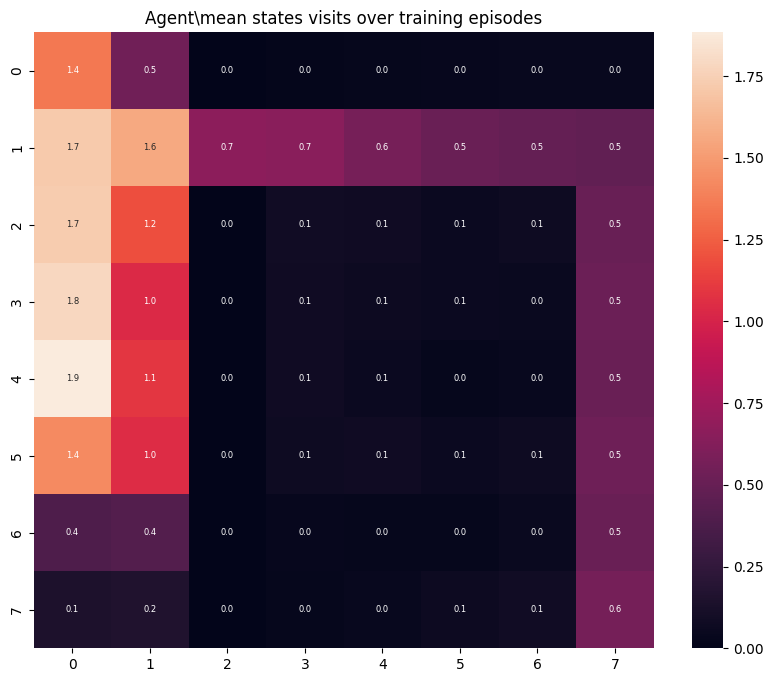

In [ ]:
sns.heatmap(states_visits_mean.T, annot=True, fmt='.1f', annot_kws={"size": 6})
plt.title('Agent\\mean states visits over training episodes');

### Training Convergence Graphs

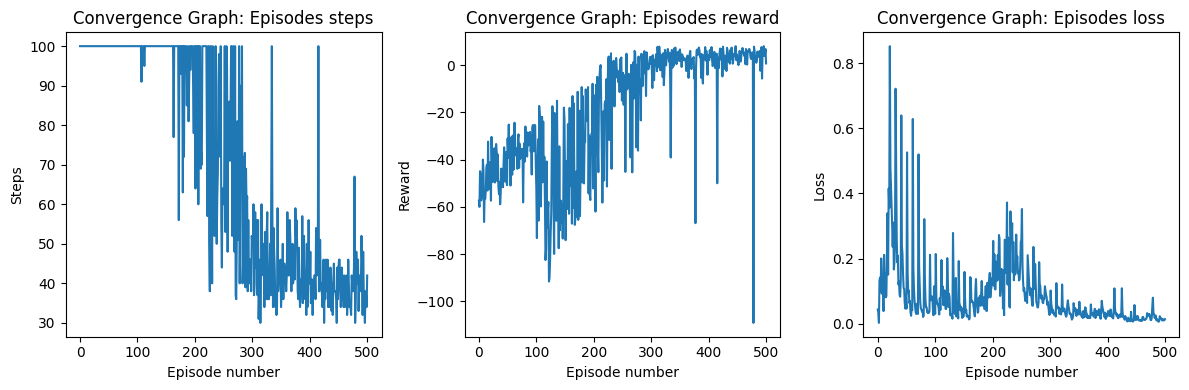

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) # Creates 1 row, 3 columns of plots, adjust figsize as needed

# Plot Episodes steps on the first subplot
axs[0].plot(episodes_steps)
axs[0].set_title('Convergence Graph: Episodes steps')
axs[0].set_xlabel('Episode number')
axs[0].set_ylabel('Steps')

# Plot Episodes reward on the second subplot
axs[1].plot(episodes_rewards)
axs[1].set_title('Convergence Graph: Episodes reward')
axs[1].set_xlabel('Episode number')
axs[1].set_ylabel('Reward')

# Plot Episodes loss on the third subplot
axs[2].plot(episodes_loss)
axs[2].set_title('Convergence Graph: Episodes loss')
axs[2].set_xlabel('Episode number')
axs[2].set_ylabel('Loss')

plt.tight_layout() # Adjusts subplots to fit into the figure area.

## Running DQN in the Key Stochastic Environment

In [ ]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments
train_num_episodes = 2000 # override episodes count according to env

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.99995,
    'num_episodes': train_num_episodes,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1,
    'dqn_version': DqnVersion.VANILLA
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.STOCHASTIC)
algorithm_params['env'] = env
mid_train_policy, policy, states_visits_mean, done_count, episodes_steps, episodes_rewards, episodes_loss = dqn(**algorithm_params)

Training Progress: 100%|██████████| 2001/2001 [12:15<00:00,  2.72it/s]


### Agent Videos

stream mid-training policy:

In [ ]:
stream_policy(env, mid_train_policy)

stream final policy:

In [ ]:
stream_policy(env, policy)

### Agent Evaluation at Test Time

In [ ]:
evaluate_policy(env, policy, test_steps_cutoff, print_results=True);

Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 34.78it/s]

Policy Evaluation Summary (over 100 trials):
- Average Steps Taken: 34.14
- Environment Solved in 83.00% of Trials


### Agent's Visits Heatmap

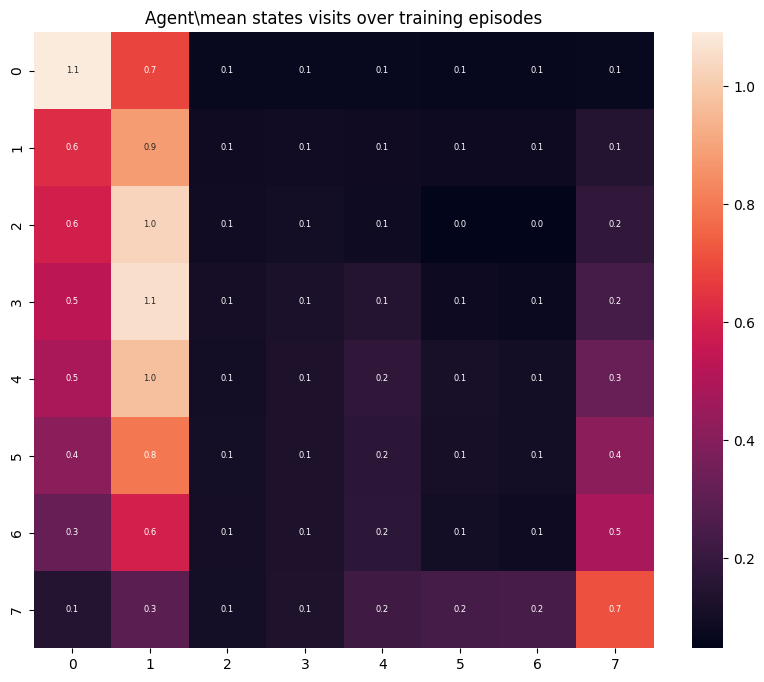

In [ ]:
sns.heatmap(states_visits_mean.T, annot=True, fmt='.1f', annot_kws={"size": 6})
plt.title('Agent\\mean states visits over training episodes');

### Training Convergence Graphs

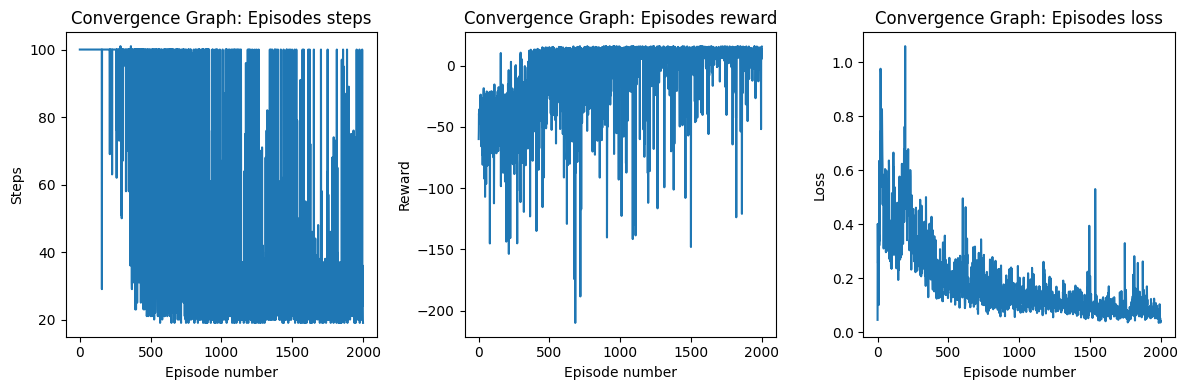

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) # Creates 1 row, 2 columns of plots, adjust figsize as needed

# Plot Episodes steps on the first subplot
axs[0].plot(episodes_steps)
axs[0].set_title('Convergence Graph: Episodes steps')
axs[0].set_xlabel('Episode number')
axs[0].set_ylabel('Steps')

# Plot Episodes reward on the second subplot
axs[1].plot(episodes_rewards)
axs[1].set_title('Convergence Graph: Episodes reward')
axs[1].set_xlabel('Episode number')
axs[1].set_ylabel('Reward')

# Plot Episodes loss on the third subplot
axs[2].plot(episodes_loss)
axs[2].set_title('Convergence Graph: Episodes loss')
axs[2].set_xlabel('Episode number')
axs[2].set_ylabel('Loss')

plt.tight_layout() # Adjusts subplots to fit into the figure area.

# Part 3: Hyperparameter Tuning and Experiments

In this section, each hyperparameter is evaluated by slightly altering its value. For each experiment, a structured summary report is presented, emphasizing assessments during both train-time and test-time:

- **Summary Table:** At test time, the learned policy is assessed over an additional 100 episodes. For each examined hyperparameter value, the table shows average steps per episode (capped at 100 due to step limits) and completion success rate.
- **Bar Plot:** Displays the number of solved episodes and their average steps during train-time.
- **Line Plot:** Tracks steps (up to 100), rewards, and losses across the training episodes.

Given the extensive computational requirements for this section, we limited our presentation to four experiments, comparing different DQN versions, learning rates, epsilon decay, and gamma. For other hyperparameters such as batch size, target network update frequency, value network update frequency, and memory buffer size, we maintained the commonly used standard values. We kept the initial epsilon value at 1 because it changes with the epsilon decay rate.

Also, onsidering that no further tuning is needed in the stochastic environment beyond increasing the number of training episodes, we will only present the results for the constant environment.

## DQN Versions

Evaluating parameter: dqn_version=vanilla.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 39.53it/s]


Evaluating parameter: dqn_version=ddqn.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 39.55it/s]


Evaluating parameter: dqn_version=dueling.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 33.82it/s]


Generating report...


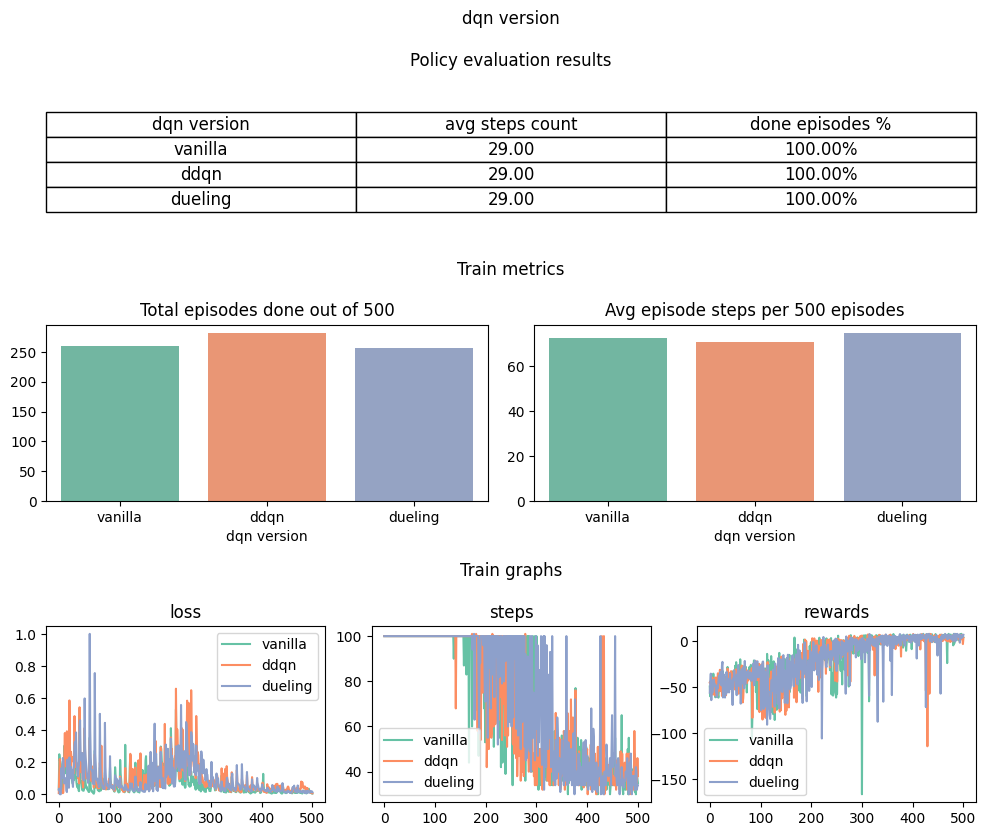

In [ ]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.99995,
    'num_episodes': 500,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1,
    'dqn_version': DqnVersion.VANILLA
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.CONSTANT)

tested_parameter = 'dqn_version'
tested_values = [DqnVersion.VANILLA, DqnVersion.DDQN, DqnVersion.DUELING]

run_experiment(env=env,
               algorithm=dqn, algorithm_params=algorithm_params,
               tested_parameter=tested_parameter, tested_values=tested_values)

Conclusion: The three DQN variations perform similarly, with a slight advantage for DDQN.

## Learning Rate

Evaluating parameter: learning_rate=0.0001.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 39.95it/s]


Evaluating parameter: learning_rate=0.0005.


Evaluation Progress: 100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


Evaluating parameter: learning_rate=0.001.


Evaluation Progress: 100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


Evaluating parameter: learning_rate=0.005.


Evaluation Progress: 100%|██████████| 100/100 [00:08<00:00, 12.22it/s]


Generating report...


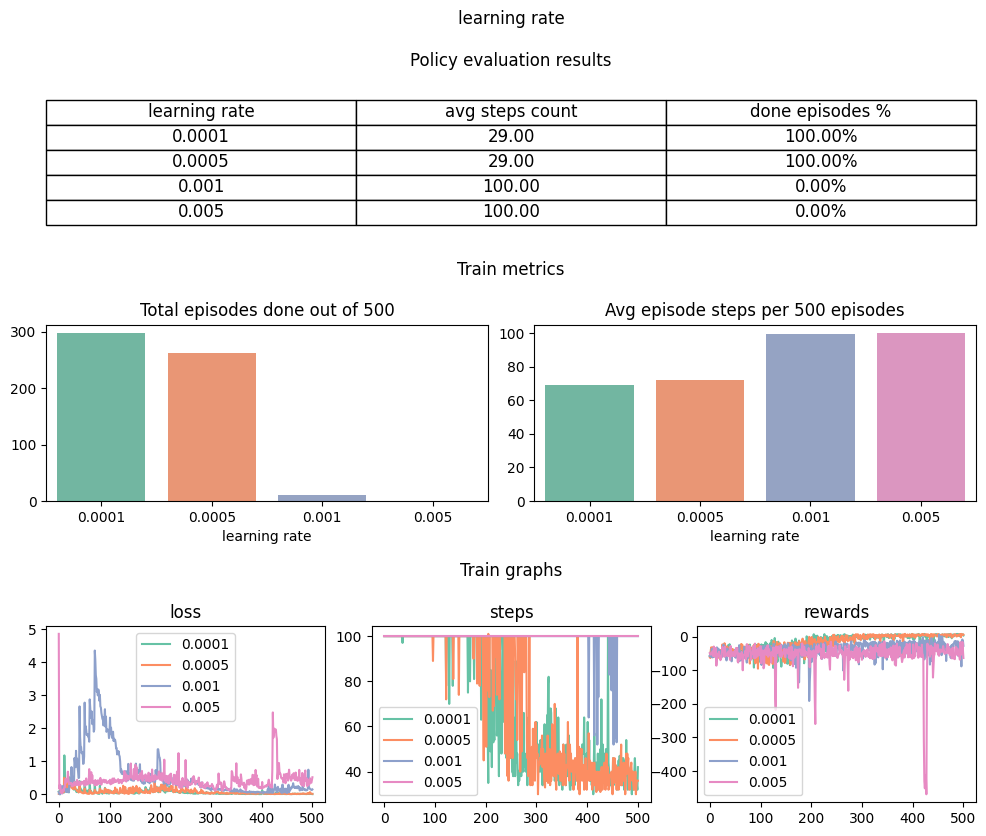

In [ ]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.99995,
    'num_episodes': 500,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1,
    'dqn_version': DqnVersion.VANILLA
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.CONSTANT)

tested_parameter = 'learning_rate'
tested_values = [0.0001, 0.0005, 0.001, 0.005]

run_experiment(env=env,
               algorithm=dqn, algorithm_params=algorithm_params,
               tested_parameter=tested_parameter, tested_values=tested_values)

Conclusion: We prefer a low learning rate that allows for slow, consistent, and stable learning over a high learning rate that likely leads to overshooting.

## Epsilon Decay

Evaluating parameter: ep_decay=0.95.


Evaluation Progress: 100%|██████████| 100/100 [00:03<00:00, 30.59it/s]


Evaluating parameter: ep_decay=0.995.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


Evaluating parameter: ep_decay=0.9995.


Evaluation Progress: 100%|██████████| 100/100 [00:03<00:00, 30.27it/s]


Evaluating parameter: ep_decay=0.99995.


Evaluation Progress: 100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Generating report...


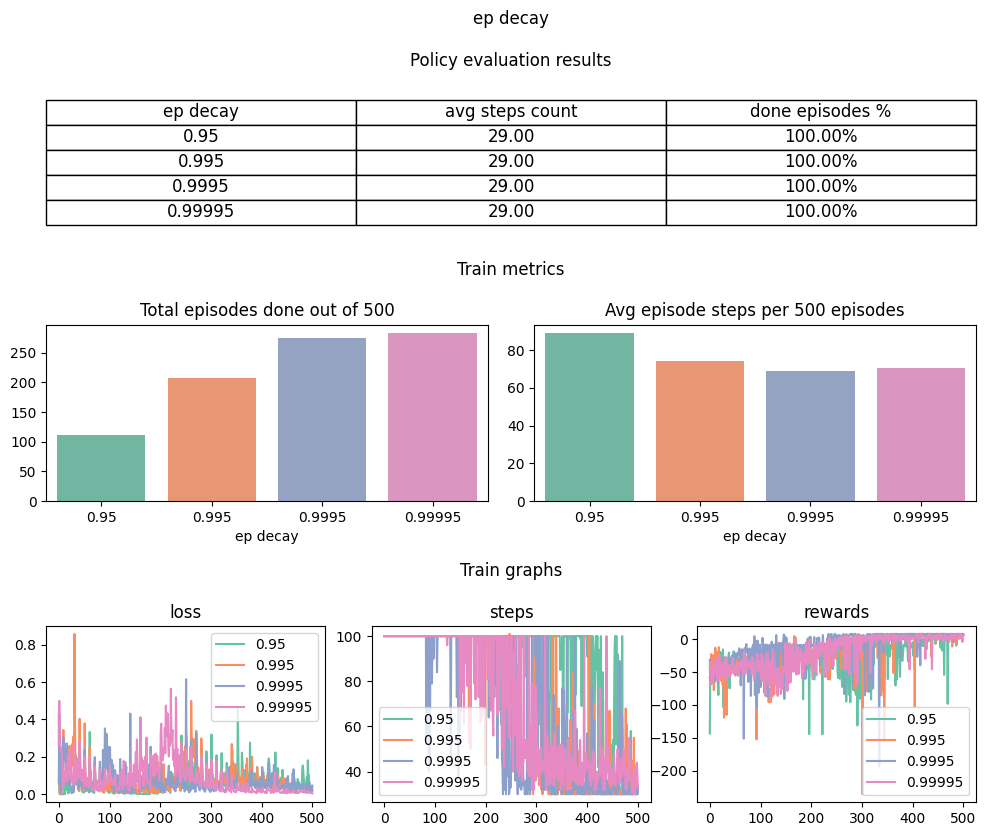

In [ ]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.99995,
    'num_episodes': 500,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1,
    'dqn_version': DqnVersion.VANILLA
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.CONSTANT)

tested_parameter = 'ep_decay'
tested_values = [0.95, 0.995, 0.9995, 0.99995]

run_experiment(env=env,
               algorithm=dqn, algorithm_params=algorithm_params,
               tested_parameter=tested_parameter, tested_values=tested_values)

Conclusion: There appears to be a preference for a high epsilon decay. We assume this preference arises because it promotes exploration, which is advantageous given the complexity of the environment: only through such exploration can we discover the key, the door, and the goal before the agent is required to strictly follow the learned policy without deviation, due to the exploitation trade-off.

## Gamma

Evaluating parameter: gamma=0.8.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 38.93it/s]


Evaluating parameter: gamma=0.85.


Evaluation Progress: 100%|██████████| 100/100 [00:03<00:00, 31.84it/s]


Evaluating parameter: gamma=0.9.


Evaluation Progress: 100%|██████████| 100/100 [00:02<00:00, 37.63it/s]


Evaluating parameter: gamma=0.95.


Evaluation Progress: 100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


Generating report...


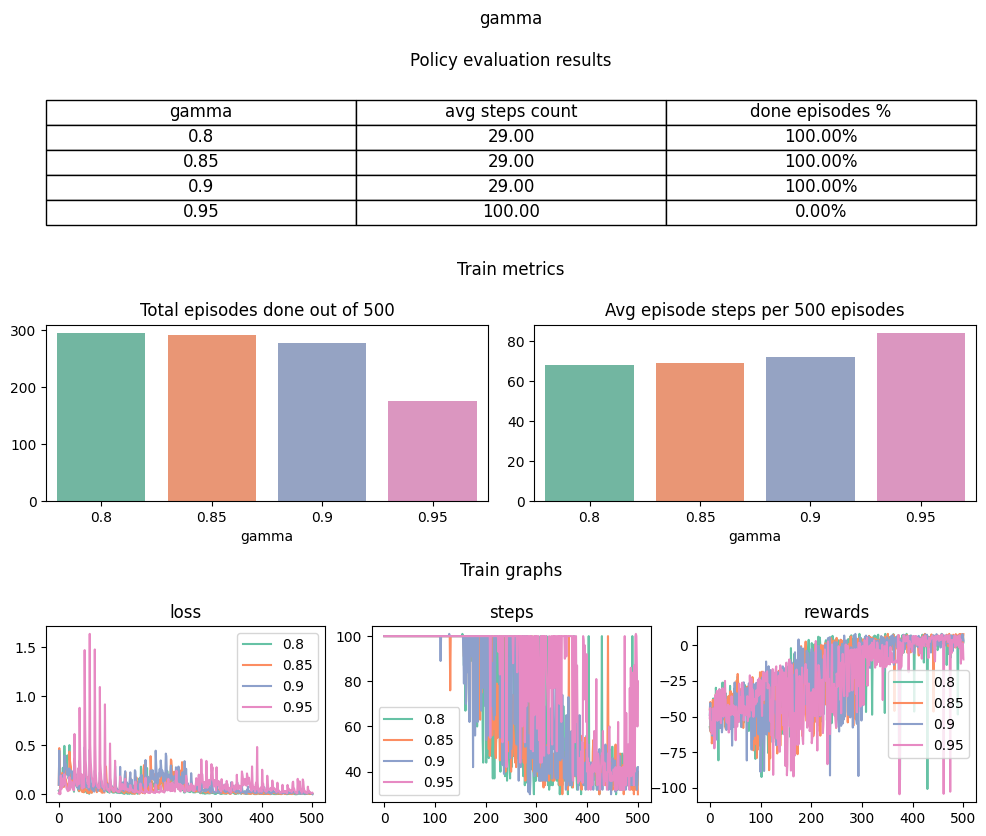

In [ ]:
random.seed(42) # set seed so our environment will be the same across repetetive experiments

'''
Default hyper-parameters values for the algorithms.
The tested hyperparameter will override its value in the relevant test
'''
algorithm_params = {
    'learning_rate': 0.0005,
    'gamma': 0.9,
    'epsilon': 1,
    'ep_decay': 0.99995,
    'num_episodes': 500,
    'steps_cutoff': train_steps_cutoff,
    'batch_size': 32,
    'target_freq_update': 10,
    'memory_buffer_size': 10000,
    'train_action_value_freq_update': 1,
    'dqn_version': DqnVersion.VANILLA
}

env = create_env(state_representation=StateRepresentation.IMAGE, env_stochasticity=EnvStochasticity.CONSTANT)

tested_parameter = 'gamma'
tested_values = [0.8, 0.85, 0.9, 0.95]

run_experiment(env=env,
               algorithm=dqn, algorithm_params=algorithm_params,
               tested_parameter=tested_parameter, tested_values=tested_values)

Conslution: It is evident that there is a preference for a gamma value that is not particularly high. We assume this is due to the fact that the agent needs to consider the rewards along the way (such as acquiring the key or opening the door), not just the one obtained from reaching the goal and completing the game.